In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!nvidia-smi

Tue Sep  5 12:47:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


In [4]:
!pip install opencv-python-headless
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm

Looking in indexes: https://test.pypi.org/simple/
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 4.2.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pytoolconfig 1.2.5 requires packaging>=22.0, but you have packaging 21.3 which is incompatible.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.2 which is incompatible.


In [5]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision
import transformers
import pytorch_lightning

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  2.0.0


A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5


In [6]:


print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__,
    "; transformers:", transformers.__version__,
    "; pytorch_lightning:", pytorch_lightning.__version__
)

roboflow: 1.1.4 ; supervision: 0.3.0 ; transformers: 4.32.1 ; pytorch_lightning: 2.0.7


In [7]:
import shutil
import os

# Define paths
train_labels_dir = '/kaggle/input/football/dataset/train/labels'
train_images_dir = '/kaggle/input/football/dataset/train/images'
test_labels_dir = '/kaggle/input/football/dataset/test/labels'
test_images_dir = '/kaggle/input/football/dataset/test/images'

merged_dir = '/kaggle/working/train_data'
merged_labels_dir = os.path.join(merged_dir, 'labels')
merged_images_dir = os.path.join(merged_dir, 'images')

# Create directories
os.makedirs(merged_labels_dir, exist_ok=True)
os.makedirs(merged_images_dir, exist_ok=True)

# Function to copy files from source to destination
def copy_files(src_dir, dest_dir):
    for file_name in os.listdir(src_dir):
        shutil.copy(os.path.join(src_dir, file_name), dest_dir)

# Merge train and test directories
copy_files(train_labels_dir, merged_labels_dir)
copy_files(train_images_dir, merged_images_dir)
copy_files(test_labels_dir, merged_labels_dir)
copy_files(test_images_dir, merged_images_dir)

split the validation directory which contains labels and images into two separate directories at a ratio of 3:1 .. 
* the first for valid 
* second for test

In [8]:
import os
import shutil
import random

# Define paths
validation_labels_dir = '/kaggle/input/football/dataset/val/labels'
validation_images_dir = '/kaggle/input/football/dataset/val/images'

split1_dir = '/kaggle/working/valid'
split1_labels_dir = os.path.join(split1_dir, 'labels')
split1_images_dir = os.path.join(split1_dir, 'images')

split2_dir = '/kaggle/working/test'
split2_labels_dir = os.path.join(split2_dir, 'labels')
split2_images_dir = os.path.join(split2_dir, 'images')

# Create directories
os.makedirs(split1_labels_dir, exist_ok=True)
os.makedirs(split1_images_dir, exist_ok=True)
os.makedirs(split2_labels_dir, exist_ok=True)
os.makedirs(split2_images_dir, exist_ok=True)

# Function to split files from source into two directories based on a ratio
def split_files(src_dir, dest_dir1, dest_dir2, ratio=0.75):
    files = os.listdir(src_dir)
    random.shuffle(files)  # Shuffle for randomness
    
    split_idx = int(len(files) * ratio)
    for i, file_name in enumerate(files):
        if i < split_idx:
            shutil.copy(os.path.join(src_dir, file_name), dest_dir1)
        else:
            shutil.copy(os.path.join(src_dir, file_name), dest_dir2)

# Split validation into split1 and split2 at a ratio of 3:1
split_files(validation_labels_dir, split1_labels_dir, split2_labels_dir, ratio=0.75)
split_files(validation_images_dir, split1_images_dir, split2_images_dir, ratio=0.75)

# Remove missing labels and images

In [9]:
import os
base_dir = '/kaggle/working/'


sub_dirs = ['train_data', 'test', 'valid']

total_removed_labels = 0

for sub in sub_dirs:
    image_dir = os.path.join(base_dir, sub, 'images')
    label_dir = os.path.join(base_dir, sub, 'labels')

    # Get the list of image files and label files
    image_files = set([f for f in os.listdir(image_dir) if f.endswith('.png')])
    label_files = set([f.replace('.txt', '.png') for f in os.listdir(label_dir) if f.endswith('.txt')])

    # Find the difference - labels that don't have corresponding image files
    unmatched_labels = label_files - image_files

    # Remove these unmatched labels
    for unmatched in unmatched_labels:
        unmatched_txt = unmatched.replace('.png', '.txt')  # Convert back to .txt for deletion
        os.remove(os.path.join(label_dir, unmatched_txt))
        # print(f"Removed {unmatched_txt} as it doesn't have a corresponding image.")
        total_removed_labels += 1

print(f"Total number of label files removed: {total_removed_labels}")

Total number of label files removed: 2518


# Remap

In [10]:

"""" Data preprocessing """



def remap_annotations_inplace(directory_path):
    """Remap annotations in the provided directory in-place."""
    
    remap_dict = {
        0: 0,  # Player team left -> Players
        1: 0,  # Player team right -> Players
        2: 1,  # Goalkeeper team left -> Goalkeeper
        3: 1,  # Goalkeeper team right -> Goalkeeper
        4: 2,  # Ball
        5: 3,  # Main referee
        6: 4,  # Side referee
        7: 5   # Staff members
    }

    for filename in os.listdir(directory_path):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory_path, filename)
            
            with open(filepath, 'r') as f:
                lines = f.readlines()

            with open(filepath, 'w') as f:
                for line in lines:
                    parts = line.strip().split()
                    class_id = int(parts[0])

                    # Remap the class ID
                    parts[0] = str(remap_dict.get(class_id, class_id))

                    f.write(' '.join(parts) + '\n')

# Paths to your original YOLO annotations
train_dir = "/kaggle/working/train_data/labels"
test_dir = "/kaggle/working/test/labels"
valid_dir = "/kaggle/working/valid/labels"

remap_annotations_inplace(train_dir)
remap_annotations_inplace(test_dir)
remap_annotations_inplace(valid_dir)

In [11]:
import os

base_dir = '/kaggle/working/'


sub_dirs = ['train_data', 'test', 'valid']

total_removed = 0

for sub in sub_dirs:
    image_dir = os.path.join(base_dir, sub, 'images')
    label_dir = os.path.join(base_dir, sub, 'labels')

    # Get the list of image files and label files
    image_files = set([f for f in os.listdir(image_dir) if f.endswith('.png')])
    label_files = set([f.replace('.txt', '.png') for f in os.listdir(label_dir) if f.endswith('.txt')])

    # Find the difference - images that don't have corresponding label files
    unmatched_images = image_files - label_files

    # Remove these unmatched images
    for unmatched in unmatched_images:
        os.remove(os.path.join(image_dir, unmatched))
        # print(f"Removed {unmatched} as it doesn't have a corresponding label.")
        total_removed += 1

print(f"Total number of images removed: {total_removed}")

import os
import json
from PIL import Image

base_dir = "/kaggle/working"  # Replace with your directory path

sub_dirs = ['train_data', 'test', 'valid']

# Assuming a mapping of class id to category name
class_map = {
    0: "Players",
    1: "Goalkeeper",
    2: "Ball",
    3: "Main referee",
    4: "Side referee",
    5: "Staff members"
    # ... add more class mappings
}

for sub in sub_dirs:
    dataset = {
        "info": {},
        "licenses": [],
        "images": [],
        "annotations": [],
        "categories": []
    }

    for cid, cname in class_map.items():
        dataset["categories"].append({
            "id": cid,
            "name": cname
        })

    image_id = 0
    annotation_id = 0

    image_dir = os.path.join(base_dir, sub, 'images')
    label_dir = os.path.join(base_dir, sub, 'labels')

    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        label_path = os.path.join(label_dir, img_file.replace('.png', '.txt'))

        # Use PIL to read image dimensions
        with Image.open(img_path) as img:
            img_width, img_height = img.size

        dataset["images"].append({
            "id": image_id,
            "file_name": img_file,
            "height": img_height,
            "width": img_width,
            "license": 0,
            "date_captured": ""
        })

        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                lines = file.readlines()
                for line in lines:
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())

                    # Convert from normalized YOLO format to COCO format
                    x_center *= img_width
                    y_center *= img_height
                    width *= img_width
                    height *= img_height
                    x_top_left = x_center - (width / 2)
                    y_top_left = y_center - (height / 2)

                    annotation = {
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": int(class_id),
                        "bbox": [x_top_left, y_top_left, width, height],
                        "area": width * height,
                        "iscrowd": 0
                    }
                    dataset["annotations"].append(annotation)
                    annotation_id += 1

        image_id += 1

    # Save the annotations.coco.json file inside the images subdirectory
    with open(os.path.join(image_dir, "annotations.coco.json"), "w") as outfile:
        json.dump(dataset, outfile)

Total number of images removed: 674


In [12]:
pwd

'/kaggle/working'

In [13]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [14]:
import os
import torchvision


# settings
ANNOTATION_FILE_NAME = "annotations.coco.json"
TRAIN_DIRECTORY = "/kaggle/working/train_data/images"
VAL_DIRECTORY ="/kaggle/working/valid/images"
TEST_DIRECTORY ="/kaggle/working/test/images"

print("Number of training images:", len(os.listdir(TRAIN_DIRECTORY)))
print("Number of validation images:", len(os.listdir(VAL_DIRECTORY)))
print("Number of test images:", len(os.listdir(TEST_DIRECTORY)))

Number of training images: 769
Number of validation images: 197
Number of test images: 22


In [15]:
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 13.4 MB/s eta 0:00:00


In [16]:
import torchvision.transforms as T

In [17]:




class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


    
# # Define the transformations here as previously discussed
# transform_train = T.Compose([
#     T.RandomHorizontalFlip(),
#     T.RandomRotation(10),
#     T.RandomResizedCrop(224),
#     T.ToTensor(),
# ])
# transform_val = T.ToTensor()

TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY, 
    image_processor=image_processor, 
    train=True
)

VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY, 
    image_processor=image_processor, 
    train=False
)

TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY, 
    image_processor=image_processor, 
    train=False
)






print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))







# TRAIN_DATASET = CocoDetection(
#     image_directory_path=TRAIN_DIRECTORY, 
#     image_processor=image_processor, 
#     train=True)
# VAL_DATASET = CocoDetection(
#     image_directory_path=VAL_DIRECTORY, 
#     image_processor=image_processor, 
#     train=False)
# TEST_DATASET = CocoDetection(
#     image_directory_path=TEST_DIRECTORY, 
#     image_processor=image_processor, 
#     train=False)

# print("Number of training examples:", len(TRAIN_DATASET))
# print("Number of validation examples:", len(VAL_DATASET))
# print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 768
Number of validation examples: 196
Number of test examples: 21


Image #218


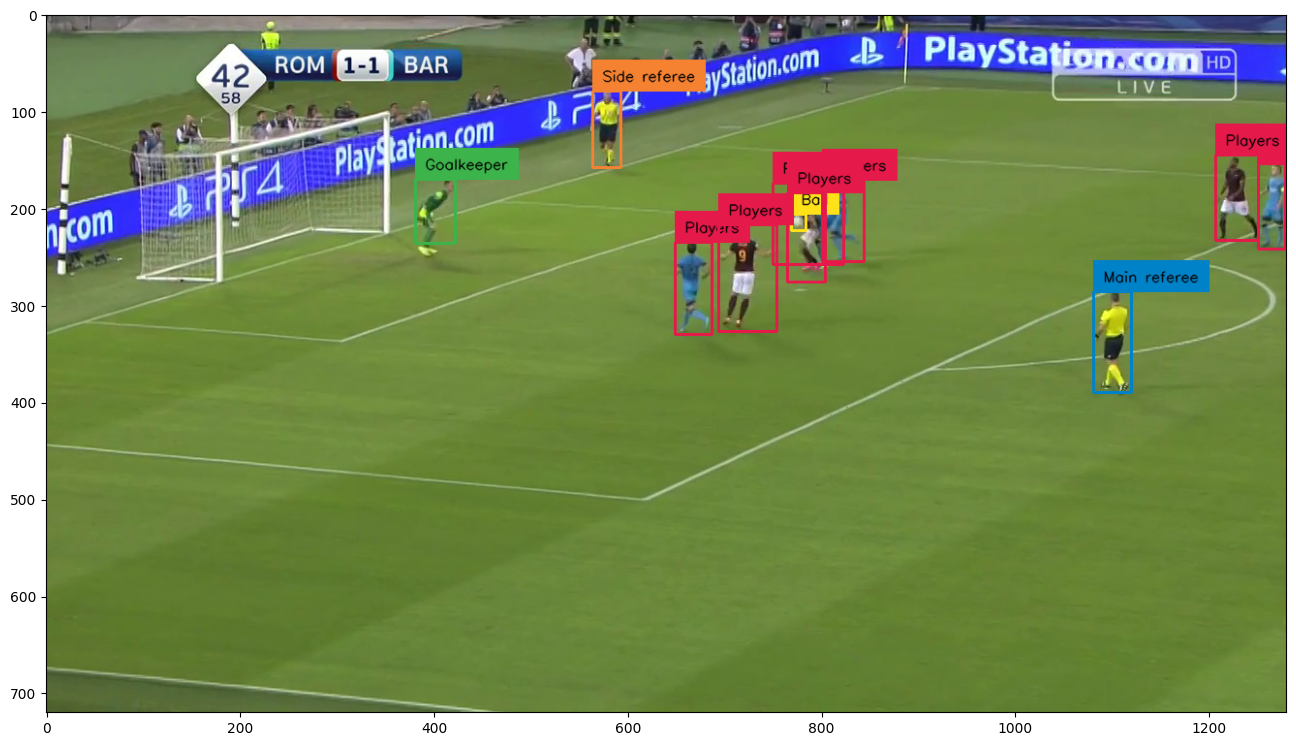

In [18]:
import random
import cv2
import numpy as np

import supervision as sv

# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _, class_id, _ 
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline  
sv.show_frame_in_notebook(image, (16, 16))

In [19]:
# from torch.utils.data import DataLoader
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible 
    # to directly batch together images. Hence they pad the images to the biggest 
    # resolution in a given batch, and create a corresponding binary pixel_mask 
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }


TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=8)
TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=8, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=8)

In [20]:
for i, (img, annotations) in enumerate(TRAIN_DATALOADER.dataset):
    print(annotations)
    if i > 1:
        break

{'size': tensor([ 750, 1333]), 'image_id': tensor([0]), 'class_labels': tensor([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4]), 'boxes': tensor([[0.5330, 0.4458, 0.0088, 0.0170],
        [0.4796, 0.3004, 0.0232, 0.0873],
        [0.6713, 0.4990, 0.0350, 0.1215],
        [0.4871, 0.4326, 0.0329, 0.1067],
        [0.4466, 0.3549, 0.0538, 0.0990],
        [0.2736, 0.4851, 0.0303, 0.1236],
        [0.4971, 0.5679, 0.0353, 0.1533],
        [0.9759, 0.4282, 0.0304, 0.1244],
        [0.5047, 0.4510, 0.0187, 0.0754],
        [0.6117, 0.2582, 0.0235, 0.0874],
        [0.6801, 0.3473, 0.0306, 0.1074],
        [0.1398, 0.6537, 0.0320, 0.1490],
        [0.6393, 0.4582, 0.0274, 0.1318],
        [0.7070, 0.1569, 0.0133, 0.0637]]), 'area': tensor([ 148.8781, 2025.2927, 4247.1777, 3513.9082, 5326.9302, 3737.5864,
        5405.0649, 3777.4958, 1410.4344, 2057.5188, 3286.2961, 4765.6445,
        3611.5049,  850.0808]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'orig_size': tensor([ 720,

In [21]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT, 
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
#         labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]
# If batch["labels"] is a list of tensors
        labels = [t.to(self.device) for t in batch["labels"]]


        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("val_loss", loss)
        for k, v in loss_dict.items():
            self.log("val_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here: 
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [22]:
%cd {HOME}

%load_ext tensorboard
%tensorboard --logdir lightning_logs/

/kaggle/working


In [23]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [24]:

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])
outputs.logits.shape

torch.Size([8, 100, 7])

In [25]:
from pytorch_lightning.callbacks import EarlyStopping

In [26]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=3,
   strict=False,
   verbose=False,
   mode='min'
)

In [27]:
from pytorch_lightning import Trainer

%cd {HOME}

# settings
MAX_EPOCHS = 60

# pytorch_lightning < 2.0.0
#  accelerator="gpu", 
# pytorch_lightning >= 2.0.0
# trainer = Trainer(devices=1,max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=16, log_every_n_steps=5)
trainer = Trainer(
    devices=1, 
    max_epochs=MAX_EPOCHS, 
    gradient_clip_val=0.1, 
    accumulate_grad_batches=8, 
    log_every_n_steps=5,
    callbacks=[early_stop_callback]
)

trainer.fit(model)

/kaggle/working


Sanity Checking: 0it [00:00, ?it/s]

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [34]:
model.to(DEVICE)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

In [35]:
MODEL_PATH = os.path.join(HOME, 'modellast')

In [36]:
import torch

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
model.to(DEVICE)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

In [38]:
torch.save(model.state_dict(), "modellast.pth")

In [39]:
model.load_state_dict(torch.load("modellast.pth", map_location=DEVICE))

<All keys matched successfully>

Image #16
ground truth


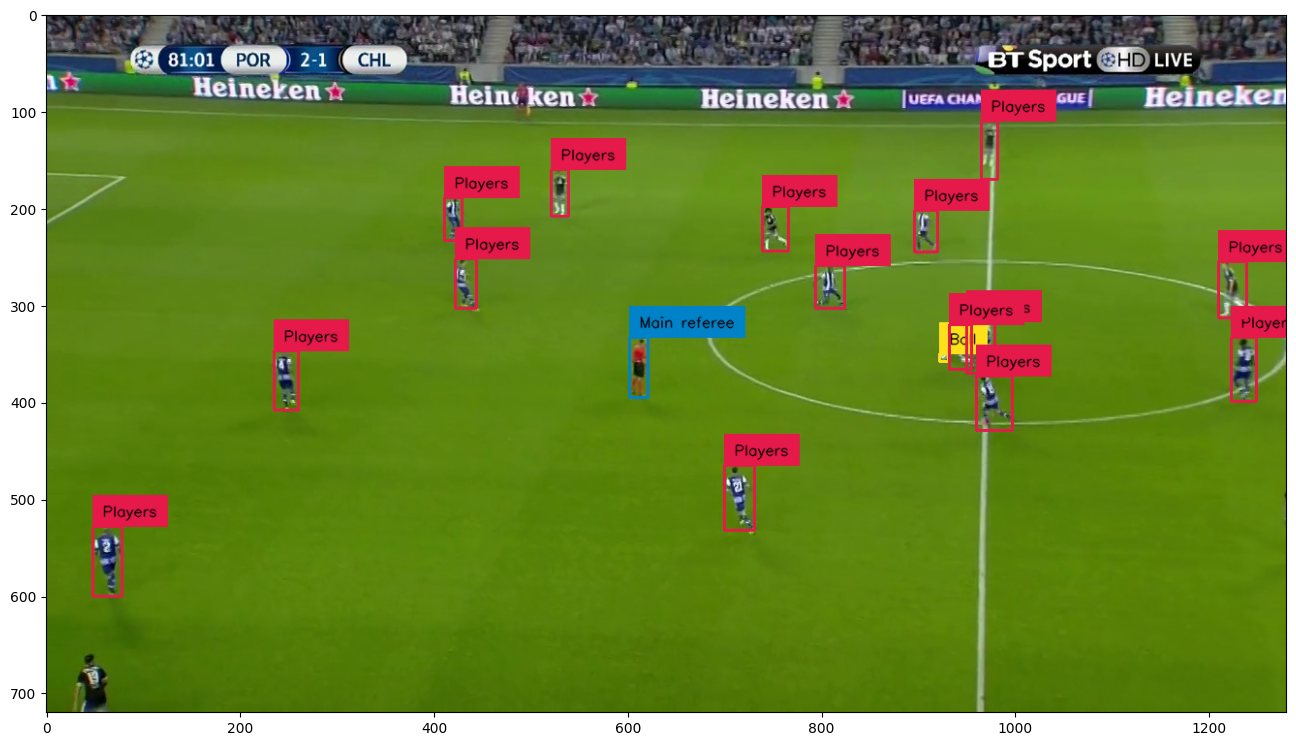

______

detections


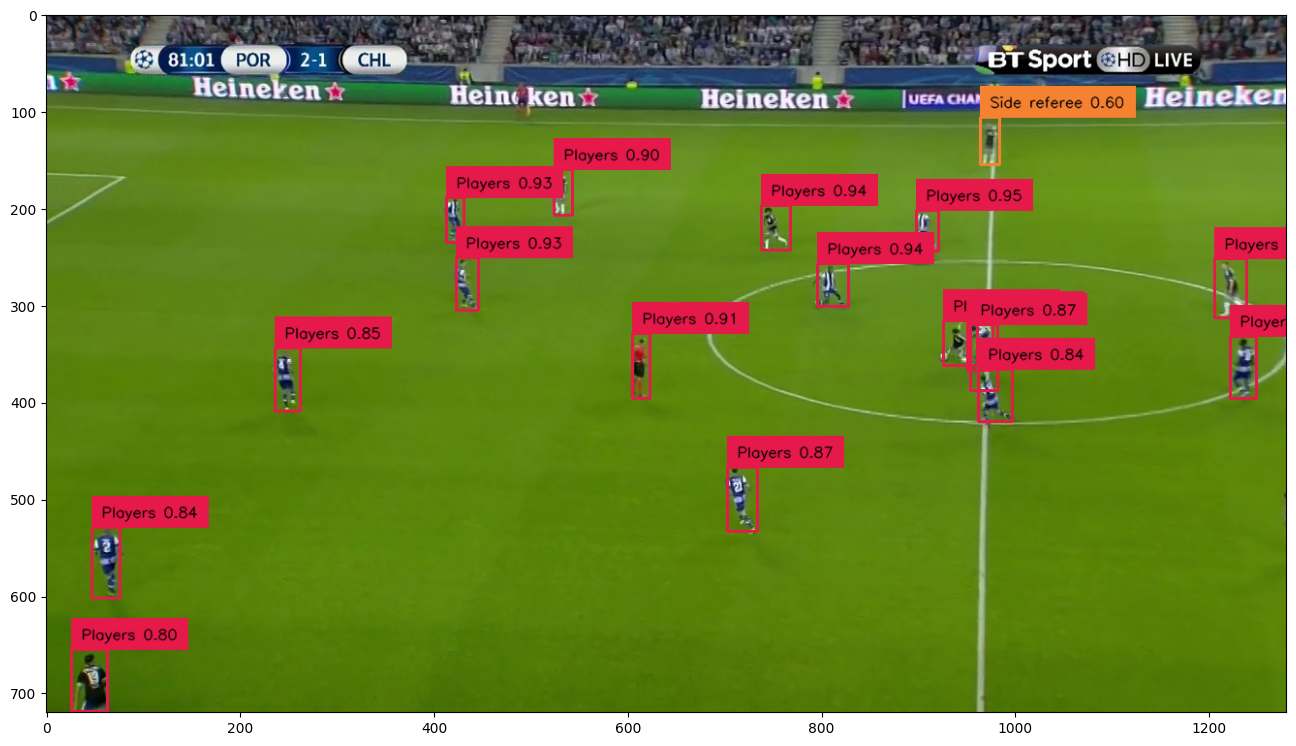

In [49]:
import random
import cv2
import numpy as np


# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()

image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('ground truth')
%matplotlib inline  
sv.show_frame_in_notebook(frame, (16, 16))
print("______\n")

# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=CONFIDENCE_TRESHOLD, 
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.7)
labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('detections')
%matplotlib inline  
sv.show_frame_in_notebook(frame, (16, 16))

i found that it detect the players well , but the goalkeeper sometimes detect it as player , i think this issue due to the implance of the classes as i have players classes more than goal keepr and other classes

Image #8
ground truth


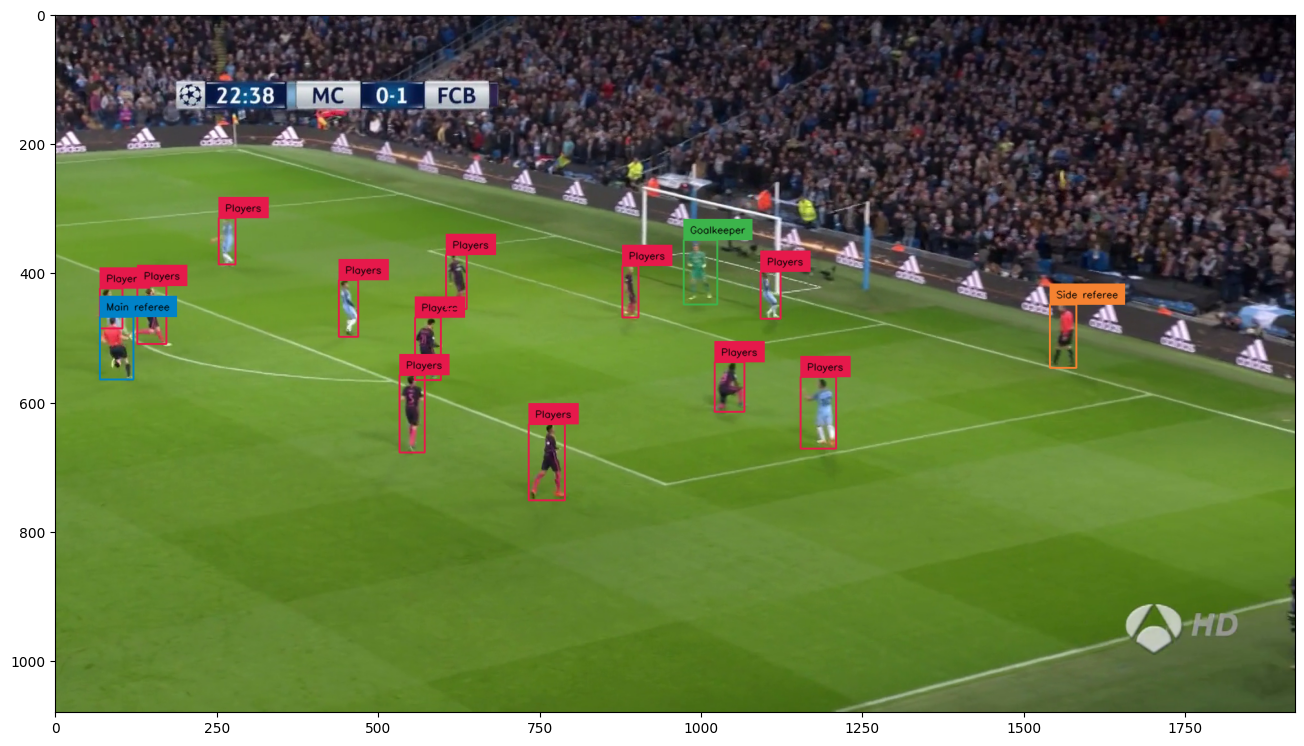

detections


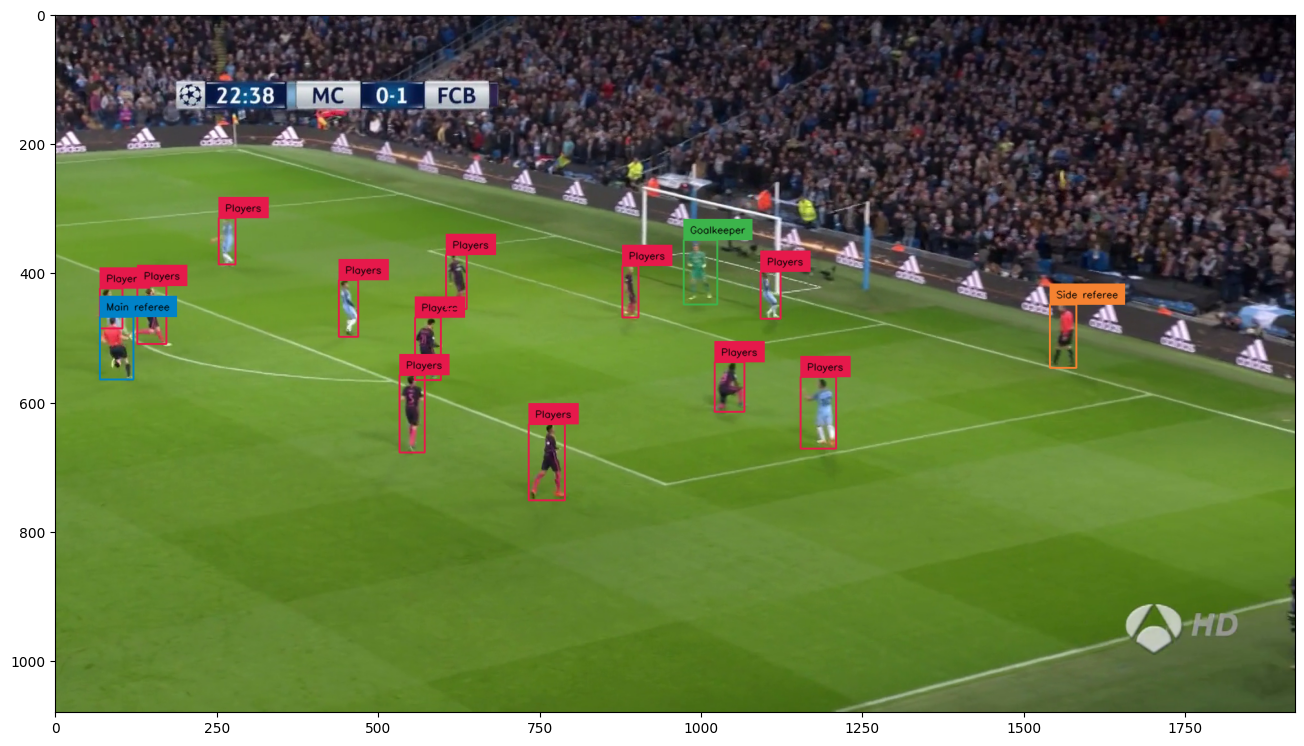

In [51]:
import random
import cv2
import numpy as np


# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()

image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('ground truth')
%matplotlib inline  
sv.show_frame_in_notebook(frame, (16, 16))

# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=CONFIDENCE_TRESHOLD, 
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.7)
labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('detections')
%matplotlib inline  
sv.show_frame_in_notebook(frame, (16, 16))

Image #17
ground truth


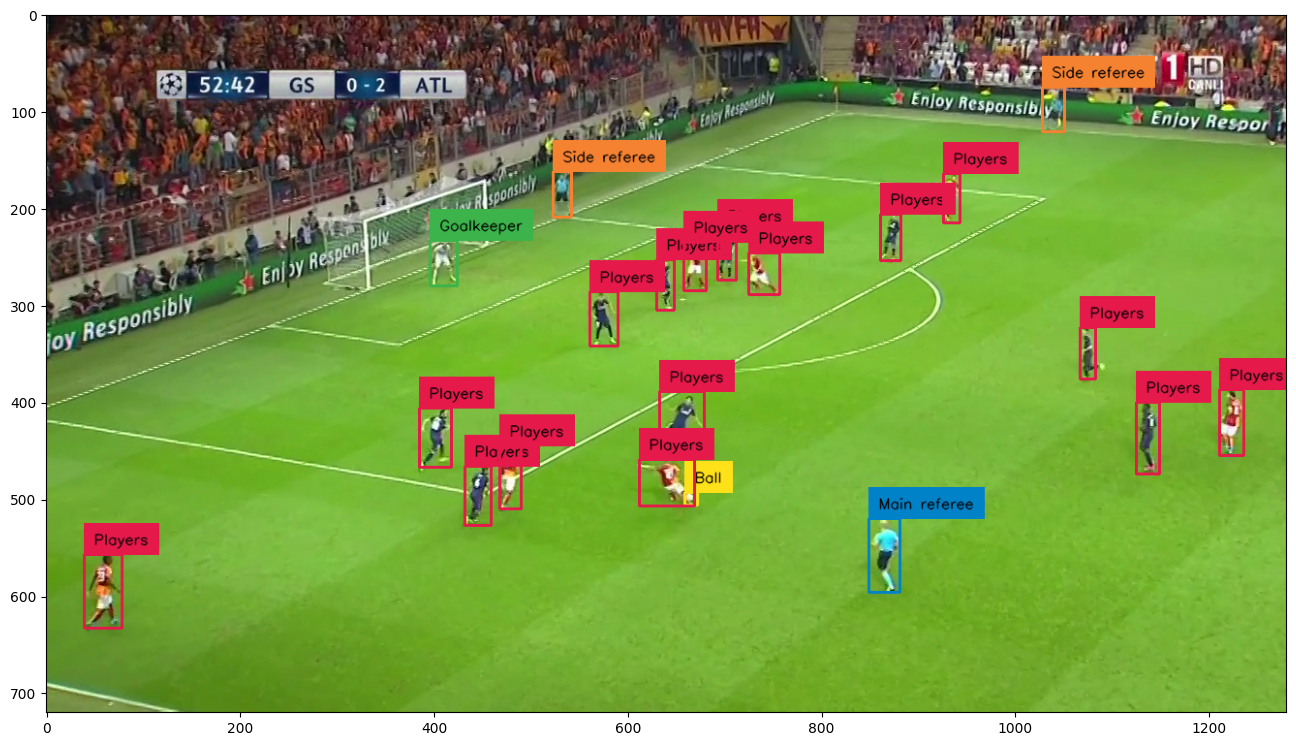

detections
Detections(xyxy=array([[ 724.44934,  243.43575,  760.30457,  289.29465],
       [ 632.8684 ,  250.29248,  656.827  ,  301.26242],
       [ 636.0442 ,  396.70197,  677.0095 ,  455.2732 ],
       [ 680.393  ,  223.26924,  703.73694,  277.94446],
       [ 463.55038,  443.5614 ,  489.53687,  514.95135],
       [ 621.4933 ,  456.3101 ,  668.30164,  508.56778],
       [ 388.28397,  406.00775,  422.9611 ,  467.568  ],
       [ 565.116  ,  286.30533,  595.2045 ,  340.87686],
       [ 435.22272,  468.261  ,  459.44604,  527.12024],
       [1207.2405 ,  387.67044, 1234.0095 ,  454.14346],
       [ 630.0389 ,  250.52367,  652.07764,  299.2309 ],
       [  39.06671,  559.9904 ,   78.24698,  640.16046],
       [1066.6918 ,  320.61008, 1090.8729 ,  380.35345],
       [ 926.145  ,  166.8056 ,  942.9094 ,  215.77519],
       [ 663.13   ,  490.12018,  680.11414,  509.50342],
       [ 659.9826 ,  233.97096,  685.1073 ,  282.99942],
       [ 861.10913,  206.10295,  883.4982 ,  254.45172],
    

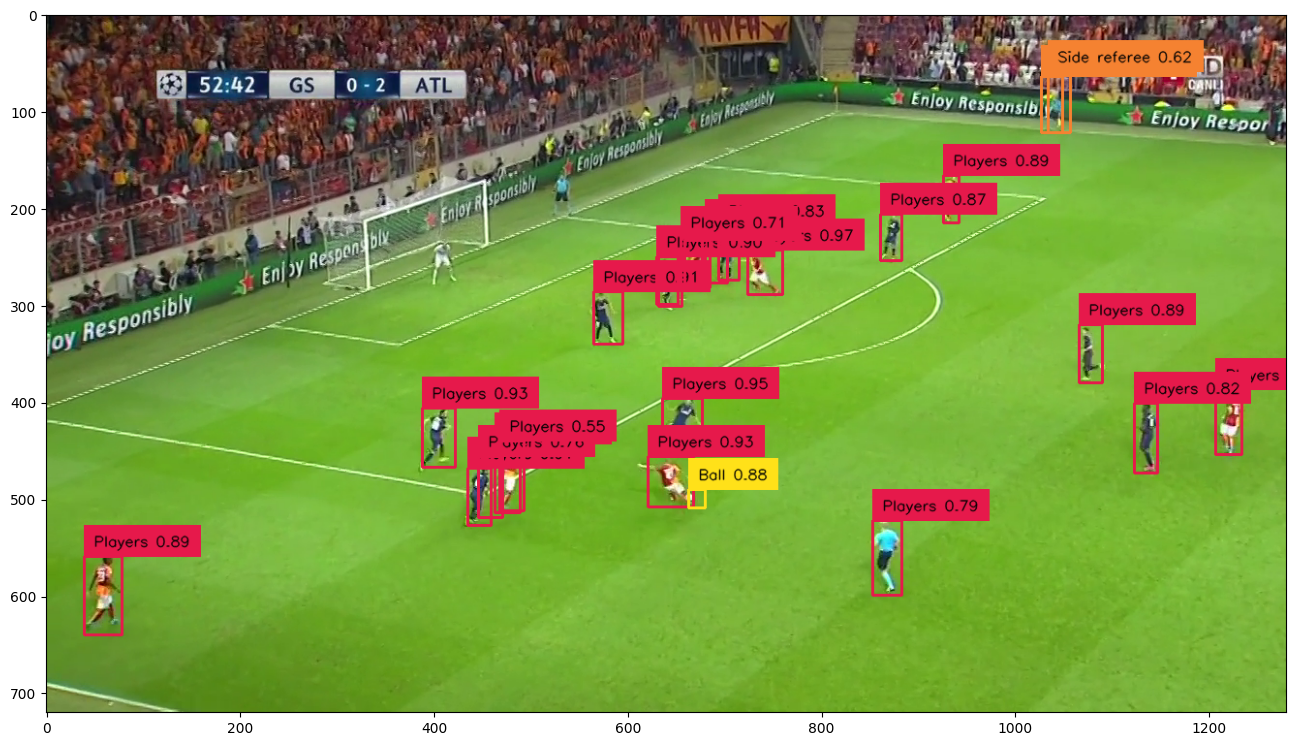

In [64]:
import random
import cv2
import numpy as np


# utils
categories = VAL_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()

image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('ground truth')
%matplotlib inline  
sv.show_frame_in_notebook(frame, (16, 16))

# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=CONFIDENCE_TRESHOLD, 
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.7)
labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('detections')
print(detections)
%matplotlib inline  
sv.show_frame_in_notebook(frame, (16, 16))

In [60]:
!pip install -q coco_eval

In [61]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [62]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

In [63]:


import numpy as np

evaluator = CocoEvaluator(coco_gt=TEST_DATASET.coco, iou_types=["bbox"])

print("Running evaluation...")

for idx, batch in enumerate(tqdm(TEST_DATALOADER)):
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/3 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.186
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [ ]:
import tensorflow as tf
import cv2
import numpy as np

# Load your MobileNet V2 classification model
classification_model = tf.keras.models.load_model('/kaggle/input/resnet/saved_model.pb')


In [69]:
import cv2
import numpy as np

image = cv2.imread('/kaggle/input/testtt/test.png')

# Assuming the `detections` variable holds your detection output
detection_boxes = detections.xyxy[:, :4]
class_ids = detections.class_id

# Process each detection
for i, (bbox, class_id) in enumerate(zip(detection_boxes, class_ids)):
    x1, y1, x2, y2 = bbox

    # Extract the ROI from the image using the bounding box coordinates
    roi = image[int(y1):int(y2), int(x1):int(x2)]

    # Preprocess the ROI for classification
    roi_resized = cv2.resize(roi, (224, 224))  # Resize to match MobileNet input size
    roi_normalized = roi_resized / 255.0  # Normalize pixel values

    # Perform classification using the MobileNet model
    prediction = classification_model.predict(np.expand_dims(roi_normalized, axis=0))

    # Get the predicted class label and confidence
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]

    # Draw bounding box and class label on the image
    color = (0, 255, 0)  # Green color for bounding box
    class_label = f'Class: {predicted_class} - Confidence: {confidence:.2f}'
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
    cv2.putText(image, class_label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Display the image with detections and classifications
cv2.imshow('Image with Detections', image)
cv2.waitKey(0)
